In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import dataloader
from transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,inject_noise
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'datasubset'
paramdir = 'dataparamsub'

# Pytorch parameters
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 256
num_epochs = 5
lr = 0.005
log_interval = 25
max_steps = 501

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 50

In [4]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'rmse', 'instID', 'midiPitch'])


In [5]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID'],  #,'midiPitch'
                                  transform=transform.Compose([inject_noise(weight=0.05),audiocoding,array2tensor(torch.FloatTensor)]), # 
                                  param_transform=dic2tensor(torch.FloatTensor),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID'],  #,'midiPitch'
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), # 
                                  param_transform=dic2tensor(torch.FloatTensor),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

(256, 1)


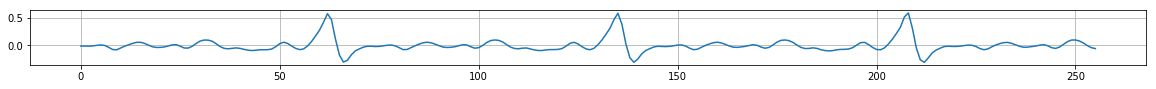

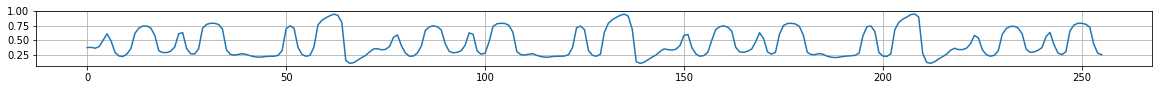

In [18]:
samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

#samp = array2tensor(torch.FloatTensor)(samp)
#rint(samp)
samp = audiocoding(samp)
#rint(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

In [8]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [19]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(epoch):
    rnn.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        #print('INP',inp.shape)
        #print("TAR",target.shape)
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = rnn.init_hidden(batch_size)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            outputs, hidden = rnn(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
            loss += criterion(outputs, torch.squeeze(target[:,i],1))
            
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        #print(count,ave_loss)
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result = generate(max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
        
        #if step==max_steps:
        #    break
        
        
def generate(max_length,primer=None,paramvect=None):
    """primer is None condition, paramvect is incomplete""" 
    with torch.no_grad():
        if primer is not None:
            p_inp = primer
        else:
            for p_inp,target in test_loader:
                seq = np.copy(p_inp[0,:,0])  #extract the original sample
                seq_mu = audiocoding(seq)  #mu-law
                p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
                break   
        generated = seq
        p_inp = p_inp.to(device)

        hidden = rnn.init_hidden()
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = rnn(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            outputs, hidden = rnn(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.cuda.FloatTensor)
            #print("input",inp)
            #print("shape",inp.shape)
            #if paramvect is None:
            #    paramvect = p_inp[:,-1,1:]
            #    input = torch.cat((input,paramtensor),1) 
            #    print("paramvect",paramvect,paramvect.shape)
                        
        return generated
        

In [10]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(1,1,40,256,4).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

2018-10-07 15:44:49 Starting training...
2018-10-07 15:45:52 Epoch [1/5], Step [25/156] Loss: 5.2240
2018-10-07 15:46:45 Epoch [1/5], Step [50/156] Loss: 5.1126


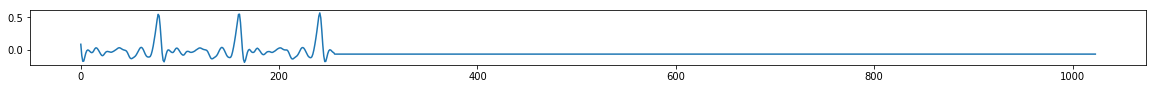

2018-10-07 15:47:41 Epoch [1/5], Step [75/156] Loss: 4.9738
2018-10-07 15:48:34 Epoch [1/5], Step [100/156] Loss: 4.6527


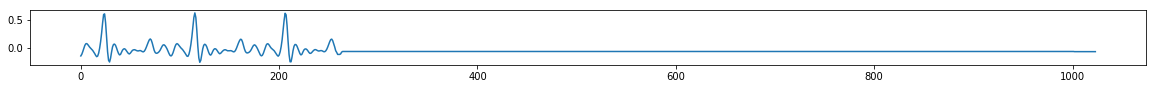

2018-10-07 15:49:36 Epoch [1/5], Step [125/156] Loss: 4.4099
2018-10-07 15:50:30 Epoch [1/5], Step [150/156] Loss: 4.2976


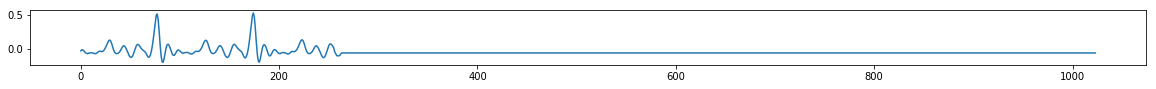

2018-10-07 15:51:43 Epoch [2/5], Step [25/156] Loss: 4.2194
2018-10-07 15:52:38 Epoch [2/5], Step [50/156] Loss: 4.1844


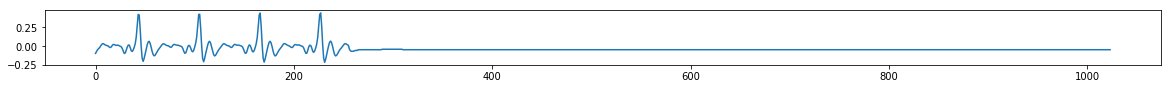

2018-10-07 15:53:33 Epoch [2/5], Step [75/156] Loss: 4.1566
2018-10-07 15:54:27 Epoch [2/5], Step [100/156] Loss: 4.1178


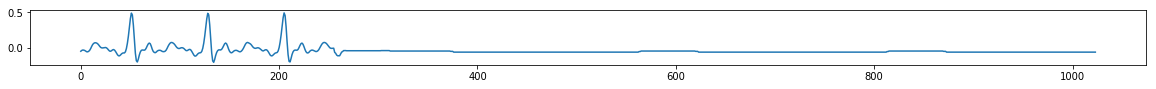

2018-10-07 15:55:26 Epoch [2/5], Step [125/156] Loss: 4.0931
2018-10-07 15:56:20 Epoch [2/5], Step [150/156] Loss: 4.0569


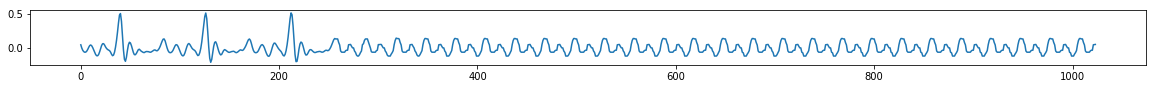

2018-10-07 15:57:33 Epoch [3/5], Step [25/156] Loss: 4.0074
2018-10-07 15:58:27 Epoch [3/5], Step [50/156] Loss: 3.9742


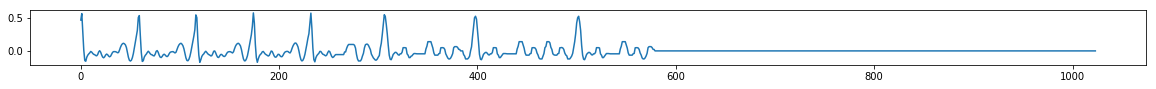

2018-10-07 15:59:22 Epoch [3/5], Step [75/156] Loss: 3.9417
2018-10-07 16:00:16 Epoch [3/5], Step [100/156] Loss: 3.8840


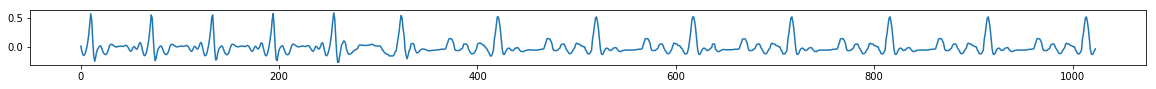

2018-10-07 16:01:15 Epoch [3/5], Step [125/156] Loss: 3.8484
2018-10-07 16:02:09 Epoch [3/5], Step [150/156] Loss: 3.8192


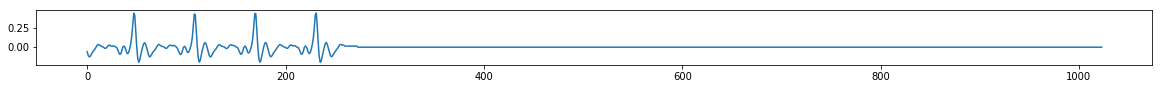

2018-10-07 16:03:22 Epoch [4/5], Step [25/156] Loss: 3.7777
2018-10-07 16:04:15 Epoch [4/5], Step [50/156] Loss: 3.7434


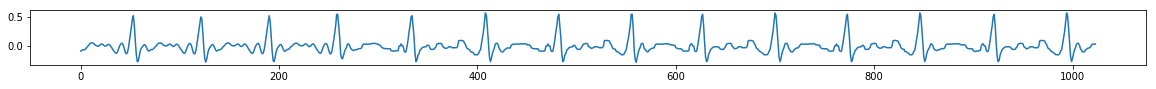

2018-10-07 16:05:11 Epoch [4/5], Step [75/156] Loss: 3.7286
2018-10-07 16:06:05 Epoch [4/5], Step [100/156] Loss: 3.7054


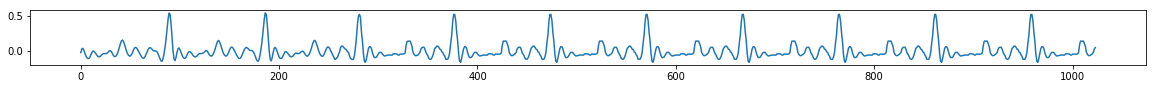

2018-10-07 16:07:05 Epoch [4/5], Step [125/156] Loss: 3.6646
2018-10-07 16:07:58 Epoch [4/5], Step [150/156] Loss: 3.6505


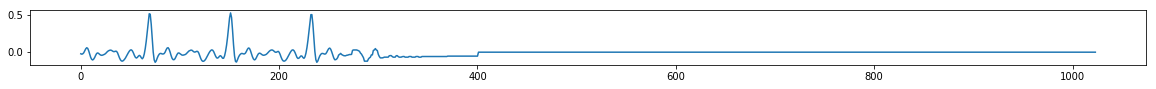

2018-10-07 16:09:14 Epoch [5/5], Step [25/156] Loss: 3.7766
2018-10-07 16:10:08 Epoch [5/5], Step [50/156] Loss: 3.6213


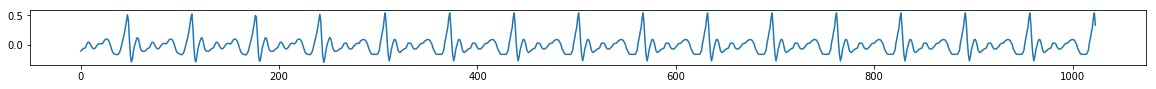

2018-10-07 16:11:03 Epoch [5/5], Step [75/156] Loss: 3.5961
2018-10-07 16:11:56 Epoch [5/5], Step [100/156] Loss: 3.5810


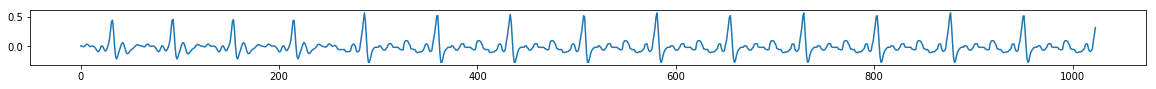

2018-10-07 16:12:56 Epoch [5/5], Step [125/156] Loss: 3.5590
2018-10-07 16:13:49 Epoch [5/5], Step [150/156] Loss: 3.5547


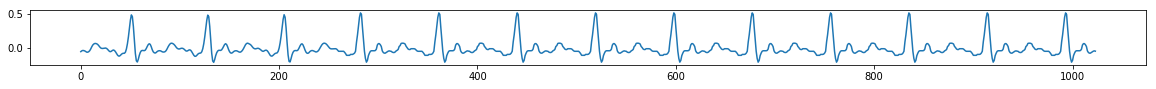

Training time taken: 0:29:10


In [11]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

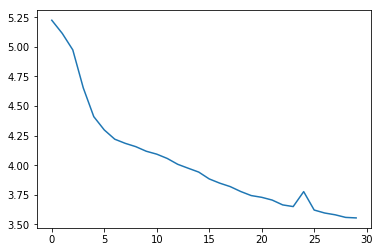

In [12]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)